In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras, profiler
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import time
import torch
from timeit import default_timer as timer
%matplotlib inline

## Define models and useful functions



In [2]:
# define model architecture

def create_LeNet(image_size = (28, 28)):
    model = tf.keras.Sequential([
        # tf.keras.layers.Rescaling(1./255),
        keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, input_shape = image_size, activation="relu"), 
        keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        keras.layers.Conv2D(16, 5, 1, activation='relu'),
        keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        keras.layers.Flatten(),
        keras.layers.Dense(120, activation='relu'), # param increase here
        keras.layers.Dense(84, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [3]:
# This function consider synchronous execution and GPU aspects to measure time more accurately

def profile_inf_time(img_expanded, model):
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    repetitions = 400
    timings=np.zeros((repetitions,1))
    #GPU-WARM-UP
    for _ in range(10):
        _ = model.predict(img_expanded)
    # MEASURE PERFORMANCE
    for rep in range(repetitions):
        starter.record()
        _ = model.predict(img_expanded)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time
    mean_syn = np.sum(timings) / repetitions
    std_syn = np.std(timings)
    time.sleep(1) # to avoid interference between each execution
    return mean_syn

In [ ]:
# determine the memory in bytes
number_size = 4.0 # default 'float32' -> memory = 4 Bytes
if K.floatx() == 'float16':
        number_size = 2.0
if K.floatx() == 'float64':
        number_size = 8.0

## Measure no. of parameters, model memory size and inference time

In [ ]:
img_size_list = []
n_params_list = []
infer_time_list = []

for i in range(1,17):
    # dummy image
    img_shape = (16*i, 16*i, 3)
    img = np.random.randint(0, 255, img_shape)
    img_expanded = np.expand_dims(img, axis=0)
    # built-in model - doesn't change no. of parameters with image shape 
    # processed_img = tf.keras.applications.vgg16.preprocess_input(img_expanded) 
    # model = tf.keras.applications.VGG16(input_shape = img_shape, classes=10, include_top=False, weights=None)
    # custom model
    model = create_LeNet(img_shape)
    curr_time = profile_inf_time(img_expanded, model)
    # get model stats
    n_params = model.count_params()
    print(f"Image shape:{img_shape[0]},\t No. of params:{n_params},\t Memory:{n_params * number_size},\t Inference time:{curr_time}")
    # append to list
    img_size_list.append(img_shape[0])
    n_params_list.append(n_params)
    infer_time_list.append(curr_time)

Image shape:16,	 No. of params:15926,	 Memory:63704.0,	 Inference time:50.71701790809632
Image shape:32,	 No. of params:62006,	 Memory:248024.0,	 Inference time:51.974321126937866
Image shape:48,	 No. of params:169526,	 Memory:678104.0,	 Inference time:52.7136953163147
Image shape:64,	 No. of params:338486,	 Memory:1353944.0,	 Inference time:52.454078893661496
Image shape:80,	 No. of params:568886,	 Memory:2275544.0,	 Inference time:52.001128349304196
Image shape:96,	 No. of params:860726,	 Memory:3442904.0,	 Inference time:52.19270341873169
Image shape:112,	 No. of params:1214006,	 Memory:4856024.0,	 Inference time:52.31022965431213
Image shape:128,	 No. of params:1628726,	 Memory:6514904.0,	 Inference time:52.99599234580994
Image shape:144,	 No. of params:2104886,	 Memory:8419544.0,	 Inference time:52.88547499656677
Image shape:160,	 No. of params:2642486,	 Memory:10569944.0,	 Inference time:53.47613292694092
Image shape:176,	 No. of params:3241526,	 Memory:12966104.0,	 Inference tim

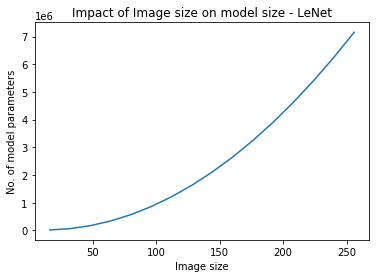

In [ ]:
plt.plot(img_size_list, n_params_list)
plt.xlabel("Image size")
plt.ylabel("No. of model parameters")
plt.title("Impact of Image size on model size - LeNet")
plt.show()

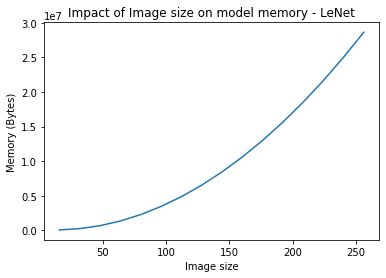

In [ ]:
memory_list = [p * number_size for p in n_params_list]
plt.plot(img_size_list, memory_list)
plt.xlabel("Image size")
plt.ylabel("Memory (Bytes)")
plt.title("Impact of Image size on model memory - LeNet")
plt.show()

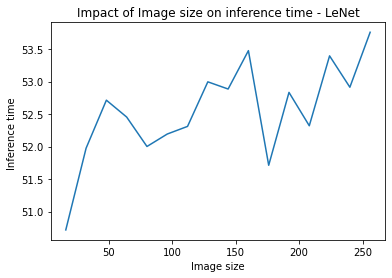

In [ ]:
plt.plot(img_size_list, infer_time_list)
plt.xlabel("Image size")
plt.ylabel("Inference time ")
plt.title("Impact of Image size on inference time - LeNet")
plt.show()

## Investigating the impact layer

In [ ]:
i=1
img_shape = (16*i, 16*i, 3) # 64 x 64
model = create_LeNet(img_shape)
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 12, 12, 6)         456       
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 6, 6, 6)          0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 2, 2, 16)          2416      
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 1, 1, 16)         0         
 g2D)                                                            
                                                                 
 flatten_38 (Flatten)        (None, 16)                0         
                                                                 
 dense_114 (Dense)           (None, 120)             

In [ ]:
i=4
img_shape = (16*i, 16*i, 3)
model = create_LeNet(img_shape)
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 60, 60, 6)         456       
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 30, 30, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 26, 26, 16)        2416      
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 flatten_39 (Flatten)        (None, 2704)              0         
                                                                 
 dense_117 (Dense)           (None, 120)             

## Measure Performance and Training time


In [4]:
# define all classes and functions

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = keras.datasets.cifar10.load_data()
	# one hot encode target values
	trainY = keras.utils.to_categorical(trainY)
	testY = keras.utils.to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test, img_size):
    # resize the images
    train = np.array(list(map( lambda x: tf.image.resize(x, (img_size, img_size)), train)))
    test = np.array(list(map( lambda x: tf.image.resize(x, (img_size, img_size)), test)))
	# convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
	# normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
	# return normalized images
    return train_norm, test_norm
 
# define cnn model
def define_model(img_shape):
	model = create_LeNet(img_shape)
	# compile model
	opt = keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test'); plt.show()

 
# run the test harness for evaluating a model
def train_n_eval(img_shape):
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX, img_shape[0])
	# define model
	model = define_model(img_shape)
	# fit model
	history = model.fit(trainX, trainY, epochs=2, batch_size=64, validation_data=(testX, testY), verbose=0)
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

In [ ]:
img_size_list = []
acc_list = []
train_time_list = []

for i in range(0,3): #6
    # define image shapes
    img_shape = (32+16*i, 32+16*i, 3)
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
    trainX, testX = prep_pixels(trainX, testX, img_shape[0])
    img_size_list.append(trainX.shape[1]) ## save
	# define model
    model = define_model(img_shape)
    # call back to record training time
    cb = TimingCallback()
	# fit model
    history = model.fit(trainX, trainY, epochs=30, batch_size=4, validation_data=(testX, testY), callbacks=[cb])
	# evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    # print('> %.3f' % (acc * 100.0))
    print("")
    print(f"Image shape:{img_shape[0]},\t Performance (accuracy): {acc * 100.0},\t Training time (sec):{sum(cb.logs)}")
    acc_list.append(acc) ## save
    train_time_list.append(sum(cb.logs))
	# learning curves
    # summarize_diagnostics(history)



170508288/170498071 [==============================] - 4s 0us/step
Epoch 1/30
12500/12500 [==============================] - 55s 4ms/step - loss: 2.0763 - accuracy: 0.2142 - val_loss: 1.7647 - val_accuracy: 0.3506
Epoch 2/30
12500/12500 [==============================] - 41s 3ms/step - loss: 1.7728 - accuracy: 0.3524 - val_loss: 1.7931 - val_accuracy: 0.3193
Epoch 3/30
12500/12500 [==============================] - 41s 3ms/step - loss: 1.7438 - accuracy: 0.3661 - val_loss: 1.7127 - val_accuracy: 0.3726
Epoch 4/30
12500/12500 [==============================] - 41s 3ms/step - loss: 1.7191 - accuracy: 0.3787 - val_loss: 1.7110 - val_accuracy: 0.3763
Epoch 5/30
12500/12500 [==============================] - 46s 4ms/step - loss: 1.7041 - accuracy: 0.3894 - val_loss: 1.6892 - val_accuracy: 0.3932
Epoch 6/30
10124/12500 [=======================>......] - ETA: 8s - loss: 1.7030 - accuracy: 0.3871

In [ ]:
plt.plot(img_size_list, acc_list)
plt.xlabel("Image size")
plt.ylabel("Accuracy (%)")
plt.title("Impact of Image size on model accuracy - LeNet")
plt.show()

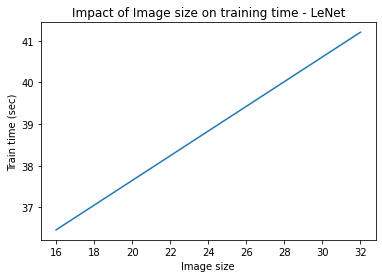

In [6]:
plt.plot(img_size_list, train_time_list)
plt.xlabel("Image size")
plt.ylabel("Train time (sec)")
plt.title("Impact of Image size on training time - LeNet")
plt.show()

In [ ]:
perf_change = [ ((acc_list[i] - acc_list[i-1])/acc_list[i-1])*100  for i in range(1, len(acc_list))]
time_change = [ ((train_time_list[i] - train_time_list[i-1])/train_time_list[i-1])*100  for i in range(1, len(train_time_list))]

perf_change.insert(0, 0) # no improvement at index 0
time_change.insert(0, 0)

In [ ]:
plt.plot(img_size_list, perf_change)
plt.xlabel("Image size")
plt.ylabel("Accuracy change (%)")
plt.title("Impact of Image size on model accuracy (change) - LeNet")
plt.show()

In [ ]:
plt.plot(img_size_list, time_change)
plt.xlabel("Image size")
plt.ylabel("Train change (%)")
plt.title("Impact of Image size on training time (change) - LeNet")
plt.show()